In [1]:
%cd ..

D:\study\codesum\code-transformer


## explore quality ~ method length

In [2]:
from ast import literal_eval
import os
import pandas as pd
import csv
from sklearn.metrics import ndcg_score
from scipy.stats import spearmanr
import numpy as np
import matplotlib.pyplot as plt

In [45]:
LANG_BINS = [3, 4, 4, 6]
MAX_TOKENS = 512

In [4]:
results_dir = 'experiments_results'
res_file = os.path.join(results_dir, 'summary.csv')

In [32]:
def divide_into_bins(data, bins = 6, min_width = 5):
    min_size = len(data) // bins
    min_size = int(min_size * 0.9)
    bin_num = 0
    out_ids = []
    bounds = []
    cur_n = 0
    for i in range(len(data)):
        if (bin_num != bins - 1 and 
            cur_n >= min_size and
            (data[i] -  (bounds[-1] if len(bounds) else 0)) >= min_width and
            i != 0 and data[i] != data[i-1]):
            bin_num += 1
            bounds.append(data[i])
            cur_n = 0
            
        out_ids.append(bin_num)
        cur_n += 1
    return out_ids, bounds

In [9]:
def get_macro_scores(tps, fps, fns):
    recalls = []
    precisions = []
    f1s = []
    for tp, fp, fn in zip(tps, fps, fns):
        if tp+fn > 0:
            recall = tp / (tp+fn)
        else:
            recall = 0
        recalls.append(recall)
        if tp+fp > 0:
            precision = tp / (tp+fp)
        else:
            precision = 0    
        precisions.append(precision)
        if precision + recall > 0:
            f1 = 2 * precision * recall / (precision + recall)
        else:
            f1 = 0
        f1s.append(f1)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    f1s = np.array(f1s)
    
    return precisions.mean(), precisions.std(), \
            recalls.mean(), recalls.std(), \
            f1s.mean(), f1s.std()


def get_micro_scores(tps, fps, fns):
    tp = sum(tps)
    fp = sum(fps)
    fn = sum(fns)
    precision = tp / (tp+fp) if (tp+fp) > 0 else 0
    recall = tp / (tp+fn) if (tp+fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    return precision, recall, f1

In [10]:
snapshot = 'latest'
partition = 'test'
models = [dict(model='code_transformer',    label='CT', run_ids=range(5, 9)), 
          dict(model='great',               label='GT', run_ids=range(1, 5)),
          dict(model='xl_net',              label='XL', run_ids=range(1, 5))]
csn_langs = ['python', 'javascript', 'ruby', 'go']


fields=['model','data', 'bins',
        'mean-precision', 'std-precision', 'mean-prec-rank-corr', 'mean-prec-ndcg',
        'mean-recall', 'std-recall', 'mean-rec-rank-corr', 'mean-rec-ndcg',
        'mean-f1', 'std-f1', 'mean-f1-rank-corr', 'mean-f1-ndcg',
        'macro-precision', 'macro-prec-rank-corr','macro-prec-ndcg',
        'macro-recall', 'macro-rec-rank-corr', 'macro-rec-ndcg',
        'macro-f1', 'macro-f1-rank-corr', 'macro-f1-ndcg',
        'rougeL-f', 'rougeL-f-rank-corr', 'rougeL-f-ndcg', 
        'chrf', 'chrf-rank-corr', 'chrf-ndcg']

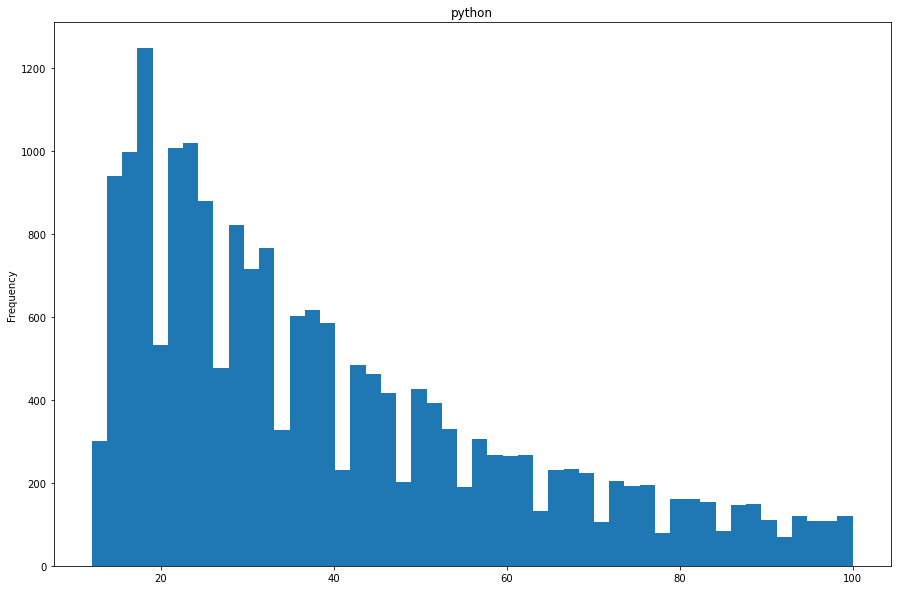

In [58]:
# lang_method_lengths = []
for i in range(5, 9):
    lang = lang = csn_langs[(i - 1) % 4]
    save_path = os.path.join(results_dir, f"sample-metrics-code_transformer-{lang}-{partition}.csv")
    if not os.path.exists(save_path):
        print(f'coudnt find file {save_path}')
        continue

    metrics = pd.read_csv(save_path)
    metrics = metrics[metrics.length <= 100]
#     print(len(metrics[metrics.length < 25]))
#     print(len(metrics[(metrics.length >= 25) & (metrics.length < 50)]))
#     print(len(metrics[metrics.length >= 50]))
#     lang_method_lengths.append(metrics.length.tolist())

    plt.figure(figsize=(15,10))
    metrics.length.plot.hist(bins=50,title=lang)
    plt.show()
    break

In [46]:
with open(res_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(fields)

for i, model_info in enumerate(models):
    model = model_info['model']
    label = model_info['label']
    for run_id in model_info['run_ids']:
        model_id = f'{label}-{run_id}'
        lang = csn_langs[(run_id - 1) % 4]
        num_bins = LANG_BINS[(run_id - 1) % 4] 
        save_path = os.path.join(results_dir, f"sample-metrics-{model}-{lang}-{partition}.csv")
        if not os.path.exists(save_path):
            print(f'coudnt find file {save_path}')
            continue

        print(f'calculating metrics for {model} {model_id} for {lang} on {partition}...')
        
        metrics = pd.read_csv(save_path)
        metrics.sort_values('length', inplace=True)
        print(f'samples num: {len(metrics)}')
        
        bin_ids, bounds = divide_into_bins(metrics.length.to_list(), num_bins)
        intervals = []
        for i in range(num_bins - 1):
            if i == 0:
                intervals.append(f'[0,{bounds[i]})')
            else:
                intervals.append(f'[{bounds[i-1]},{bounds[i]})')
        intervals.append(f'[{bounds[-1]},{MAX_TOKENS}]')
        print(f'splitted into bins:', ', '.join(intervals))
        
        metrics['bin'] = bin_ids
        groups = metrics.groupby('bin')
        metrics_bins = [groups.get_group(g) for g in groups.groups]
        print(f'bins sizes:', [len(metric_bin) for metric_bin in metrics_bins])
        
        pmu, pstd, rmu, rstd, fmu, fstd = map(list, zip(*[get_macro_scores(b.tp.tolist(), 
                                                                 b.fp.tolist(), 
                                                                 b.fn.tolist()) 
                                                          for b in metrics_bins]))
        prec, rec, f1 = map(list, zip(*[get_micro_scores(b.tp.tolist(), b.fp.tolist(), b.fn.tolist())
                                        for b in metrics_bins]))
        rouge1 = [b['rouge1-f'].mean() for b in metrics_bins] 
        rouge2 = [b['rouge2-f'].mean() for b in metrics_bins]
        rougel = [b['rougeL-f'].mean() for b in metrics_bins]
        chrf = [b['chrf'].apply(lambda s: float(s.split(' ')[-1])).mean() for b in metrics_bins]
        
        ranks = list(range(num_bins, 0, -1))
        with open(res_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([model, lang, ', '.join(intervals),
                             pmu, pstd, spearmanr(ranks, pmu).correlation, ndcg_score([ranks], [pmu]),
                             rmu, rstd, spearmanr(ranks, rmu).correlation, ndcg_score([ranks], [rmu]),
                             fmu, fstd, spearmanr(ranks, fmu).correlation, ndcg_score([ranks], [fmu]),
                             prec, spearmanr(ranks, prec).correlation, ndcg_score([ranks], [prec]),
                             rec, spearmanr(ranks, rec).correlation, ndcg_score([ranks], [rec]),
                             f1, spearmanr(ranks, f1).correlation, ndcg_score([ranks], [f1]),
                             rougel, spearmanr(ranks, rougel).correlation, ndcg_score([ranks], [rougel]),
                             chrf, spearmanr(ranks, chrf).correlation, ndcg_score([ranks], [chrf])])
        print('-----------------------------------------------------------------')

calculating metrics for code_transformer CT-5 for python on test...
samples num: 22080
splitted into bins: [0,27), [27,49), [49,512]
bins sizes: [6923, 6710, 8447]
-----------------------------------------------------------------
calculating metrics for code_transformer CT-6 for javascript on test...
samples num: 4313
splitted into bins: [0,25), [25,38), [38,63), [63,512]
bins sizes: [1032, 1020, 993, 1268]
-----------------------------------------------------------------
calculating metrics for code_transformer CT-7 for ruby on test...
samples num: 2228
splitted into bins: [0,22), [22,30), [30,46), [46,512]
bins sizes: [563, 521, 503, 641]
-----------------------------------------------------------------
calculating metrics for code_transformer CT-8 for go on test...
samples num: 14256
splitted into bins: [0,17), [17,22), [22,32), [32,47), [47,81), [81,512]
bins sizes: [2195, 3366, 2243, 2191, 2171, 2090]
-----------------------------------------------------------------
calculating me

In [42]:
summary = pd.read_csv(res_file)

for col, dtype in summary.dtypes.items():
    if col in {'model', 'data', 'bins'}:
        continue
    if dtype == np.float64:
        summary[col] = summary[col].map(lambda x: round(x, 2))
    else:
        summary[col] = summary[col].apply(lambda x: list(map(lambda y: round(y, 2), literal_eval(x))))

In [43]:
summary[['model', 'data', 
         'mean-f1-rank-corr', 'mean-f1-ndcg', 
         'macro-f1-rank-corr', 'macro-f1-ndcg', 
         'rougeL-f-rank-corr', 'rougeL-f-ndcg', 
         'chrf-rank-corr', 'chrf-ndcg'
      
#          'mean-precision', 'std-precision','mean-prec-rank-corr', 'mean-prec-ndcg', 
#          'mean-recall', 'std-recall', 'mean-rec-rank-corr', 'mean-rec-ndcg', 
#          'mean-f1', 'std-f1', 'mean-f1-rank-corr', 'mean-f1-ndcg', 
#          'macro-precision', 'macro-prec-rank-corr', 'macro-prec-ndcg', 
#          'macro-recall', 'macro-rec-rank-corr', 'macro-rec-ndcg', 
#          'macro-f1', 'macro-f1-rank-corr', 'macro-f1-ndcg', 
#          'rougeL-f', 'rougeL-f-rank-corr', 'rougeL-f-ndcg',
#          'chrf', 'chrf-rank-corr', 'chrf-ndcg'
        ]]

,model,data,mean-f1-rank-corr,mean-f1-ndcg,macro-f1-rank-corr,macro-f1-ndcg,rougeL-f-rank-corr,rougeL-f-ndcg,chrf-rank-corr,chrf-ndcg
0,code_transformer,python,0.98,1.00,0.95,0.99,0.95,0.99,0.95,1.00
1,code_transformer,javascript,0.40,0.88,0.40,0.88,0.20,0.86,0.20,0.86
2,code_transformer,ruby,1.00,1.00,1.00,1.00,1.00,1.00,0.80,0.95
3,code_transformer,go,0.94,0.97,0.94,0.97,0.94,0.97,0.94,0.97
4,great,python,0.98,1.00,0.98,1.00,0.98,1.00,0.98,1.00
5,great,javascript,0.40,0.91,0.80,0.95,0.40,0.91,-0.40,0.87
6,great,ruby,0.80,0.98,0.80,0.98,0.80,0.98,0.80,0.98
7,great,go,0.94,0.97,0.94,0.97,0.94,0.97,0.94,0.97
8,xl_net,python,0.98,1.00,0.98,1.00,0.98,1.00,0.95,1.00
9,xl_net,javascript,0.20,0.86,0.20,0.86,-0.40,0.84,-0.40,0.84


In [44]:
summary[['model', 'data', 
         'mean-f1','mean-f1-rank-corr', 'mean-f1-ndcg', 
         'macro-f1', 'macro-f1-rank-corr', 'macro-f1-ndcg', 
         'rougeL-f', 'rougeL-f-rank-corr', 'rougeL-f-ndcg', 
         'chrf','chrf-rank-corr', 'chrf-ndcg'
      
#          'mean-precision', 'std-precision','mean-prec-rank-corr', 'mean-prec-ndcg', 
#          'mean-recall', 'std-recall', 'mean-rec-rank-corr', 'mean-rec-ndcg', 
#          'mean-f1', 'std-f1', 'mean-f1-rank-corr', 'mean-f1-ndcg', 
#          'macro-precision', 'macro-prec-rank-corr', 'macro-prec-ndcg', 
#          'macro-recall', 'macro-rec-rank-corr', 'macro-rec-ndcg', 
#          'macro-f1', 'macro-f1-rank-corr', 'macro-f1-ndcg', 
#          'rougeL-f', 'rougeL-f-rank-corr', 'rougeL-f-ndcg',
#          'chrf', 'chrf-rank-corr', 'chrf-ndcg'
        ]][summary.data == 'ruby']

,model,data,mean-f1,mean-f1-rank-corr,mean-f1-ndcg,macro-f1,macro-f1-rank-corr,macro-f1-ndcg,rougeL-f,rougeL-f-rank-corr,rougeL-f-ndcg,chrf,chrf-rank-corr,chrf-ndcg
2,code_transformer,ruby,"[0.27, 0.26, 0.25, 0.23]",1.0,1.00,"[0.31, 0.28, 0.27, 0.24]",1.0,1.00,"[0.29, 0.27, 0.26, 0.24]",1.0,1.00,"[25.96, 25.97, 25.71, 24.04]",0.8,0.95
6,great,ruby,"[0.23, 0.2, 0.22, 0.2]",0.8,0.98,"[0.26, 0.23, 0.24, 0.21]",0.8,0.98,"[0.24, 0.21, 0.22, 0.21]",0.8,0.98,"[25.93, 22.26, 24.3, 21.77]",0.8,0.98
10,xl_net,ruby,"[0.26, 0.25, 0.28, 0.23]",0.4,0.88,"[0.29, 0.27, 0.3, 0.25]",0.4,0.88,"[0.28, 0.27, 0.28, 0.24]",0.8,0.98,"[26.18, 26.87, 28.39, 25.38]",0.2,0.86
